In [1]:
import numpy as np
import matplotlib as plt
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

In [2]:
# Stereo Camera Model
class StereoModel:
    def __init__(self, w=640, h=480):
        self.w = w
        self.h = h
        
        self.mat1  = np.eye(3, 3)  # camera matrix
        self.dist1 = np.zeros(6)   # distortion
        self.r1    = np.eye(3, 3)  # rotation
        self.t1    = np.zeros((3, 1)) # translation 
        self.mat1[0][0] = w/2
        self.mat1[1][1] = w/2
        self.mat1[0][2] = w/2
        self.mat1[1][2] = h/2
        self.r1[0][0] = 1
        self.r1[1][1] = -1
        self.r1[2][2] = -1
        self.t1[0][0] = +100
        self.t1[1][0] = 0
        self.t1[2][0] = 200
        
        self.mat2  = np.eye(3, 3)  # camera matrix
        self.dist2 = np.zeros(6)   # distortion
        self.r2    = np.eye(3, 3)  # rotation
        self.t2    = np.zeros((3, 1)) # translation 
        self.mat2[0][0] = w/2
        self.mat2[1][1] = w/2
        self.mat2[0][2] = w/2
        self.mat2[1][2] = h/2
        self.r2[0][0] = 1
        self.r2[1][1] = -1
        self.r2[2][2] = -1
        self.t2[0][0] = -100
        self.t2[1][0] = 0
        self.t2[2][0] = 200
    
    def CalibrateCamera1(self, objpt_list, img1pt_list, flags=0):
        rvec1 = cv2.Rodrigues(self.r1)[0]
        ret = cv2.calibrateCamera([objpt_list.astype(np.float32)], [img1pt_list.astype(np.float32)], (self.w, self.h), self.mat1, self.dist1, [rvec1], self.t1, flags)
        self.mat1  = ret[1]
        self.dist1 = ret[2]
        self.r1    = cv2.Rodrigues(ret[3][0])[0]
        self.t1    = ret[4][0]
        return ret[0]
    
    def CalibrateCamera2(self, objpt_list, img2pt_list, flags=0):
        rvec2 = cv2.Rodrigues(self.r2)[0]
        ret = cv2.calibrateCamera([objpt_list.astype(np.float32)], [img2pt_list.astype(np.float32)], (self.w, self.h), self.mat2, self.dist2, [rvec2], self.t2, flags)
        self.mat2  = ret[1]
        self.dist2 = ret[2]
        self.r2    = cv2.Rodrigues(ret[3][0])[0]
        self.t2    = ret[4][0]
        return ret[0]
    
    def StereoCalibrate(self, objpt_list, img1pt_list, img2pt_list, flags=0):
        ret = cv2.stereoCalibrate([objpt_list.astype(np.float32)], [img1pt_list.astype(np.float32)], [img2pt_list.astype(np.float32)], self.mat1, self.dist1, self.mat2, self.dist2, (self.w, self.h), flags)
        self.mat1  = ret[1]
        self.dist1 = ret[2]
        self.mat2 = ret[3]
        self.dist2 = ret[4]
        self.R = ret[5]
        self.T = ret[6]
        self.E = ret[7]
        self.F = ret[8]
        return ret[0]
    
    def GetProjectionMatrix(self):
        prjmat1 = np.dot(self.mat1, np.hstack((self.r1, self.t1)))
        prjmat2 = np.dot(self.mat2, np.hstack((self.r2, self.t2)))
        return prjmat1, prjmat2
    
    def ObjToImg(self, objpt):
        prjmat1, prjmat2 = self.GetProjectionMatrix()
        objpt = np.append(np.array(objpt), 1).reshape(4, 1)
        img1pt = np.dot(prjmat1, objpt)
        img2pt = np.dot(prjmat2, objpt)
        return np.array([img1pt[0][0]/img1pt[2][0], img1pt[1][0]/img1pt[2][0]]), np.array([img2pt[0][0]/img2pt[2][0], img2pt[1][0]/img2pt[2][0]])
    
    def ImgToObj(self, img1pt, img2pt):
        prjmat1, prjmat2 = self.GetProjectionMatrix()
        objpt = cv2.triangulatePoints(prjmat1, prjmat2, img1pt, img2pt)
        objpt = cv2.convertPointsFromHomogeneous(objpt.reshape(1, 4))[0][0]
        return objpt

    # 再投影誤差(X-Yそれぞれの二乗誤差)計算
    def CalcReprojectionError(self, objpt_list, img1pt_list, img2pt_list):
        err1 = np.zeros(2)
        err2 = np.zeros(2)
        n = 0
        for i, objpt in enumerate(objpt_list):
            img1pt, img2pt = self.ObjToImg(objpt)
            err1 += (img1pt - img1pt_list[i])**2
            err2 += (img2pt - img2pt_list[i])**2
            n += 1
        return err1 / n, err2 / n
    
    # ステレオ計測誤差(X-Y-Zそれぞれの二乗誤差)計算
    def CalcStereoError(self, objpt_list, img1pt_list, img2pt_list):
        err = np.zeros(3)
        n = 0
        for i, objpt in enumerate(objpt_list):
            img1pt = img1pt_list[i]
            img2pt = img2pt_list[i]
            err += (self.ImgToObj(img1pt, img2pt) - objpt)**2
            n += 1
        return err / n
        
    

In [3]:
# ステレオモデル作成
sm = StereoModel()

In [4]:
# 調整点の物体座標を作成
objpt_list = np.ndarray((0, 3))
for z in range(-10, +20, 10):
    for y in range(-100, +100+50, 50):
        for x in range(-150, +150+50, 50):
            objpt_list = np.vstack((objpt_list, [x, y, z]))

# 撮影される画像座標を作成
img1pt_list = np.ndarray((0, 2))
img2pt_list = np.ndarray((0, 2))
for objpt in objpt_list:
    pt1, pt2 = sm.ObjToImg(objpt)
    img1pt_list = np.vstack((img1pt_list, pt1))
    img2pt_list = np.vstack((img2pt_list, pt2))

# 真値としてコピーを保存
true_objpt_list = objpt_list.copy()
true_img1pt_list = img1pt_list.copy()
true_img2pt_list = img2pt_list.copy()

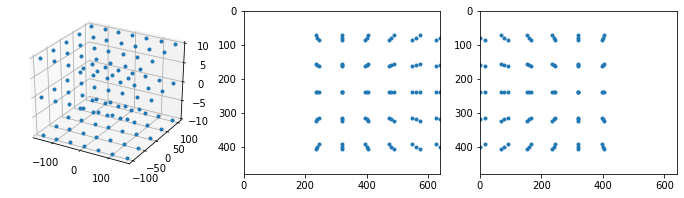

In [5]:
fig = plt.figure(figsize=(12, 3))

# 物体座標を表示
axObj = fig.add_subplot(131, projection='3d')
axObj.plot(objpt_list[:,0], objpt_list[:,1], objpt_list[:,2], '.')

# 画像座標1を表示
axImg1 = fig.add_subplot(132)
axImg1.plot(img1pt_list[:,0], img1pt_list[:,1], '.')
axImg1.set_xlim(0, sm.w)
axImg1.set_ylim(sm.h, 0)

# 画像座標2を表示
axImg2 = fig.add_subplot(133)
axImg2.plot(img2pt_list[:,0], img2pt_list[:,1], '.')
axImg2.set_xlim(0, sm.w)
axImg2.set_ylim(sm.h, 0)

plt.show()

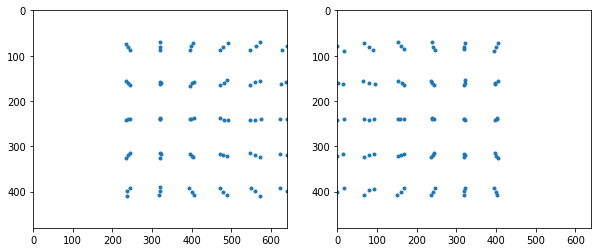

In [6]:
# ランダムに揺らぎを加える
img1pt_list = true_img1pt_list + np.random.normal(0, 1.0, true_img1pt_list.shape)
img2pt_list = true_img2pt_list + np.random.normal(0, 1.0, true_img2pt_list.shape)

# 表示
fig = plt.figure(figsize=(10, 4))

# 画像座標1を表示
axImg1 = fig.add_subplot(121)
axImg1.plot(img1pt_list[:,0], img1pt_list[:,1], '.')
axImg1.set_xlim(0, sm.w)
axImg1.set_ylim(sm.h, 0)

# 画像座標2を表示
axImg2 = fig.add_subplot(122)
axImg2.plot(img2pt_list[:,0], img2pt_list[:,1], '.')
axImg2.set_xlim(0, sm.w)
axImg2.set_ylim(sm.h, 0)

plt.show()

In [7]:
# calibration
retval = sm.CalibrateCamera1(objpt_list, img1pt_list, cv2.CALIB_USE_INTRINSIC_GUESS)
print('retval =', retval)
retval = sm.CalibrateCamera2(objpt_list, img2pt_list, cv2.CALIB_USE_INTRINSIC_GUESS)
print('retval =', retval)
retval = sm.StereoCalibrate(objpt_list, img1pt_list, img2pt_list, cv2.CALIB_USE_INTRINSIC_GUESS)
print('retval =', retval)
print('\n')

print('mat1 =\n', sm.mat1)
print('dist1 =\n', sm.dist1)
print('r1 =\n', sm.r1)
print('t1 =\n', sm.t1)
print('mat2 =\n', sm.mat2)
print('dist2 =\n', sm.dist2)
print('r2 =\n', sm.r2)
print('t2 =\n', sm.t2)
print('R =\n', sm.R)
print('T =\n', sm.T)
print('E =\n', sm.E)
print('F =\n', sm.F)

retval = 1.4359242499852645
retval = 1.3612193328519226
retval = 1.3990704992647103


mat1 =
 [[321.6358538    0.         313.37360374]
 [  0.         319.55188719 236.08339377]
 [  0.           0.           1.        ]]
dist1 =
 [[ 0.01027709]
 [-0.00124067]
 [-0.00086952]
 [-0.00712026]
 [-0.00031814]]
r1 =
 [[ 9.99957430e-01  6.63360677e-04 -9.20315613e-03]
 [ 6.50799132e-04 -9.99998853e-01 -1.36784470e-03]
 [-9.20405295e-03  1.36179707e-03 -9.99956715e-01]]
t1 =
 [[104.43629806]
 [  2.6120346 ]
 [199.65489087]]
mat2 =
 [[320.38175565   0.         323.62346111]
 [  0.         320.29786554 245.73053019]
 [  0.           0.           1.        ]]
dist2 =
 [[-1.97726894e-03]
 [-1.97562455e-04]
 [ 1.09458585e-03]
 [-1.44352054e-03]
 [-9.19863161e-05]]
r2 =
 [[ 9.99998953e-01  1.43581988e-03  1.81103823e-04]
 [ 1.43495632e-03 -9.99988012e-01  4.68155914e-03]
 [ 1.87823528e-04 -4.68129436e-03 -9.99989025e-01]]
t2 =
 [[-101.96215063]
 [  -3.71323224]
 [ 200.28704393]]
R =
 [[ 9.99955669e-0

In [8]:
# 再投影誤差
sm.CalcReprojectionError(true_objpt_list, img1pt_list, img2pt_list)

(array([11.46335463,  1.32744199]), array([1.05541962, 1.12477008]))

In [9]:
# ステレオ計測誤差
sm.CalcStereoError(true_objpt_list, img1pt_list, img2pt_list)

array([0.5565354 , 0.61742951, 4.26064564])

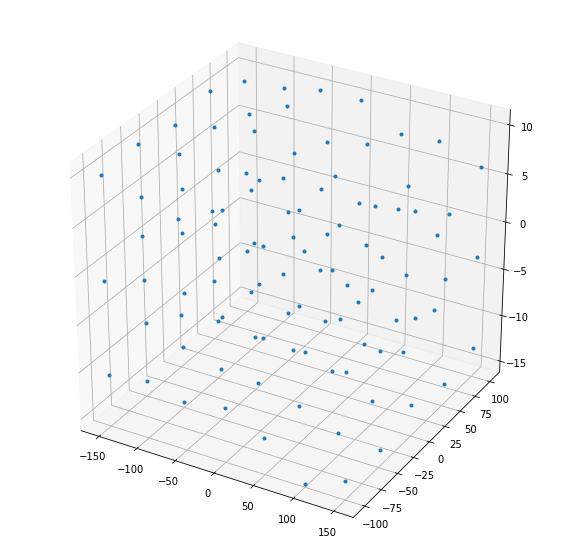

In [10]:
# 物体座標を再計算
calc_objpt_list = np.ndarray((0, 3))
for i, img1pt in enumerate(img1pt_list):
    img2pt = img2pt_list[i]
    objpt = sm.ImgToObj(img1pt, img2pt)
    calc_objpt_list = np.vstack((calc_objpt_list, objpt))

# 表示
fig = plt.figure(figsize=(10, 10))

# 物体座標を表示
axObj = fig.add_subplot(111, projection='3d')
axObj.plot(calc_objpt_list[:,0], calc_objpt_list[:,1], calc_objpt_list[:,2], '.')

plt.show()